# Google Notebook specific Stuff

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install pytorch-lightning==1.3.3
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
!pip install scGeneFit
!pip install scanpy
!pip install anndata
!pip install lassonet
# my version of smashpy that fixed imports, nothing else was changed
!pip install matplotlib>=3.3.2
!pip install shap>=0.37.0
!pip install xgboost>=1.3.3
!pip install imbalanced-learn>=0.7.0
!pip install numba>=0.51.2
!pip install harmonypy>=0.0.5
!pip install smashpy
!git clone https://github.com/ahsv/RankCorr.git

fatal: destination path 'RankCorr' already exists and is not an empty directory.


In [ ]:
# Check GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
import sys
import os
# to import utils
sys.path.append(os.path.abspath('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks'))

# All the Imports

In [ ]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier



from RankCorr.picturedRocks import Rocks
import smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


CPU times: user 4.01 s, sys: 513 ms, total: 4.52 s
Wall time: 4.49 s


# These should be parameters later on 

In [ ]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 5

gpus = 1
tpu_cores = None

In [ ]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [ ]:
from os import path

In [ ]:
dataset_dir = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/paul/'
model_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/paul/models/'
viz_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/paul/visualizations/'

if not path.exists(model_save_path):
  os.mkdir(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.mkdir(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.mkdir(viz_save_path)

  

# Dataset Specific Processing

`

In [ ]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [ ]:
sm = smashpy.smashpy()
housekeeping_gene_direct = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/housekeeping_genes/'
sm.data_preparation(adata)
adata = sm.remove_general_genes(adata)
adata = sm.remove_housekeepingenes(adata, path=[housekeeping_gene_direct + "house_keeping_genes_Mouse_bone_marrow.txt"])
adata = sm.remove_housekeepingenes(adata, path=[housekeeping_gene_direct + "house_keeping_genes_Mouse_HSC.txt"])

 * Initialising ...


In [ ]:
dict_annotation = {}

dict_annotation['1Ery']='Ery'
dict_annotation['2Ery']='Ery'
dict_annotation['3Ery']='Ery'
dict_annotation['4Ery']='Ery'
dict_annotation['5Ery']='Ery'
dict_annotation['6Ery']='Ery'
dict_annotation['7MEP']='MEP'
dict_annotation['8Mk']='Mk'
dict_annotation['9GMP']='GMP'
dict_annotation['10GMP']='GMP'
dict_annotation['11DC']='DC'
dict_annotation['12Baso']='Baso'
dict_annotation['13Baso']='Baso'
dict_annotation['14Mo']='Mo'
dict_annotation['15Mo']='Mo'
dict_annotation['16Neu']='Neu'
dict_annotation['17Neu']='Neu'
dict_annotation['18Eos']='Eos'
dict_annotation['19Lymph']='Lymph'

annotation = []
for celltype in adata.obs["paul15_clusters"].tolist():
    annotation.append(dict_annotation[celltype])

adata.obs['annotation'] = annotation
adata.obs['annotation'] = adata.obs['annotation'].astype("category")

In [ ]:
adata.obs

paul15_clusters  n_counts annotation
0               7MEP     353.0        MEP
1               15Mo    2556.0         Mo
2               3Ery    4649.0        Ery
3               15Mo    4486.0         Mo
4               3Ery    5205.0        Ery
...              ...       ...        ...
2725            2Ery    4873.0        Ery
2726          13Baso    3553.0       Baso
2727            7MEP     443.0        MEP
2728            15Mo    3252.0         Mo
2729            3Ery    6401.0        Ery

[2730 rows x 3 columns]

In [ ]:
adata.shape

(2730, 3113)

In [ ]:
np.apply_along_axis(np.mean, 0, adata.X)

array([0.6347514 , 0.37418288, 1.5362046 , ..., 0.45775437, 1.5907574 ,
       0.11060051], dtype=float32)

In [ ]:
np.apply_along_axis(np.var, 0, adata.X)

array([0.8668631 , 0.556478  , 1.3638892 , ..., 0.72055787, 1.4972948 ,
       0.22075835], dtype=float32)

In [ ]:
X = adata.X.copy()
labels = adata.obs['annotation'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [ ]:
input_size = X.shape[1]

In [ ]:
X.shape

(2730, 3113)

# Set Up Models

### Baseline

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

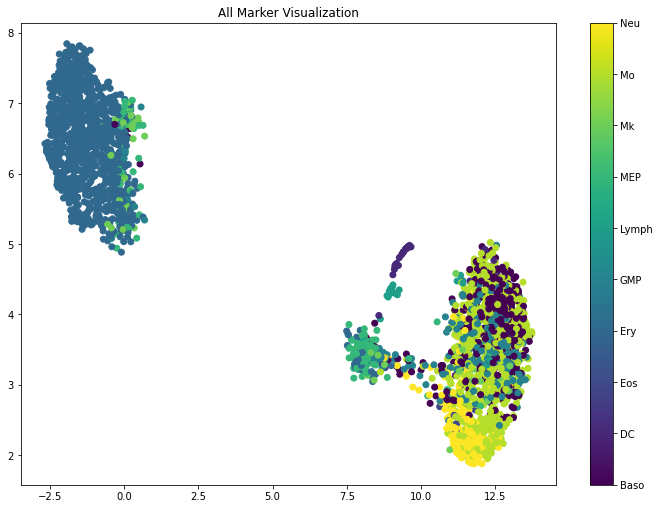

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

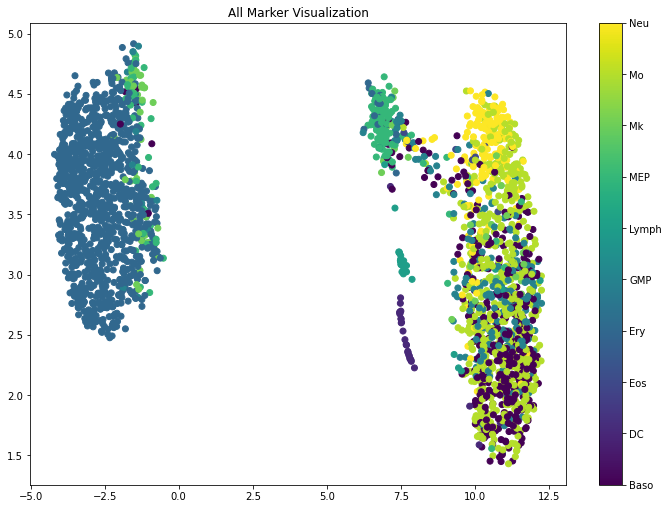

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



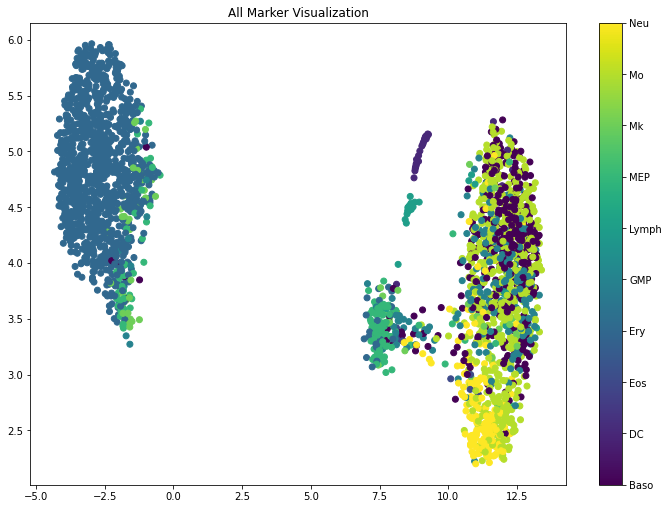

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

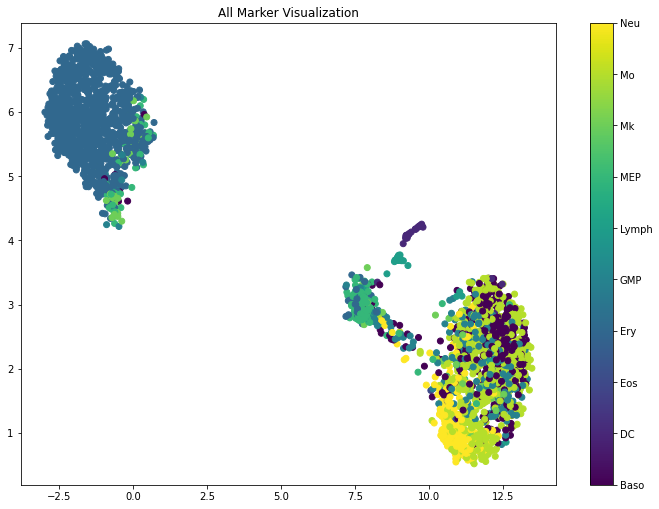

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

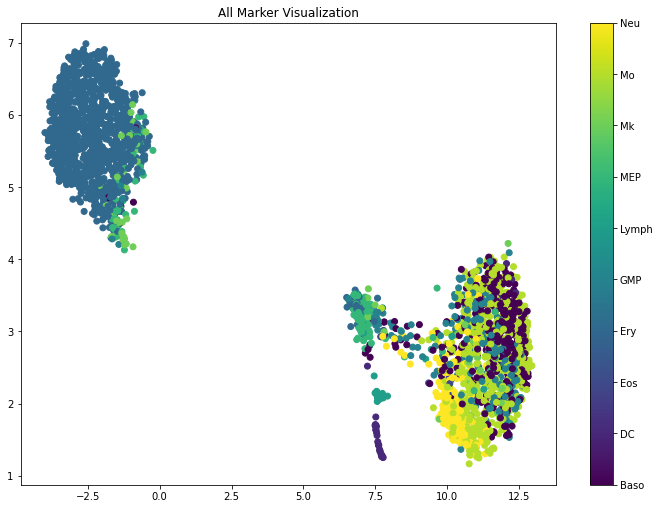

CPU times: user 2min 32s, sys: 1.62 s, total: 2min 33s
Wall time: 2min 5s


In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)

## Train Smash Random Forest





In [ ]:
# needed for random forest Smash
!mkdir Figures

In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

In [ ]:
results

## Train Smash DNN

the data is treated a bit differently than our other models

In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

In [ ]:
results

## Train RankCorr

In [ ]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 4.7# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        print("Excess Length of markers")
        print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

In [ ]:
len(rankcorr_markers)

In [ ]:
print("Some, if not all, selected gene names")
print(marker_genes)

In [ ]:
results

## Train L1 VAE

In [ ]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = 16)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

In [ ]:
results

## Train Global Gate

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

In [ ]:
model.t

In [ ]:
results

## Train Running State VAE

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = VAE_Gumbel_RunningState(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae_markers_{}.npy'.format(tryy), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE Marker Visualization', path = viz_save_path + 'runningstate_vae_markers_{}.png'.format(tryy), markers = runningstate_markers)

In [ ]:
model.t

In [ ]:
results

In [ ]:
model.t

## Running State Classifier

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = GumbelClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_classifier_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_classifier_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_classifier_markers_{}.npy'.format(tryy), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_classifier_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State Classifier Marker Visualization', path = viz_save_path + 'runningstate_classifier_markers_{}.png'.format(tryy), markers = runningstate_markers)

In [ ]:
model.lr

In [ ]:
model.t

In [ ]:
model.hparams.lr

In [ ]:
results

## RunningState VAE+Classifier

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


New Learning Rate 0.0006300037000000001


Validation sanity check: 0it [00:00, ?it/s]

Training: 9it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



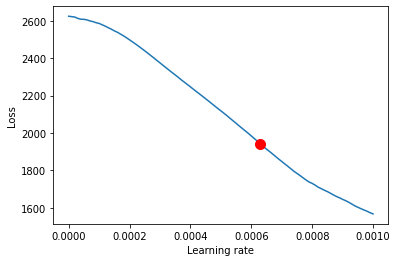

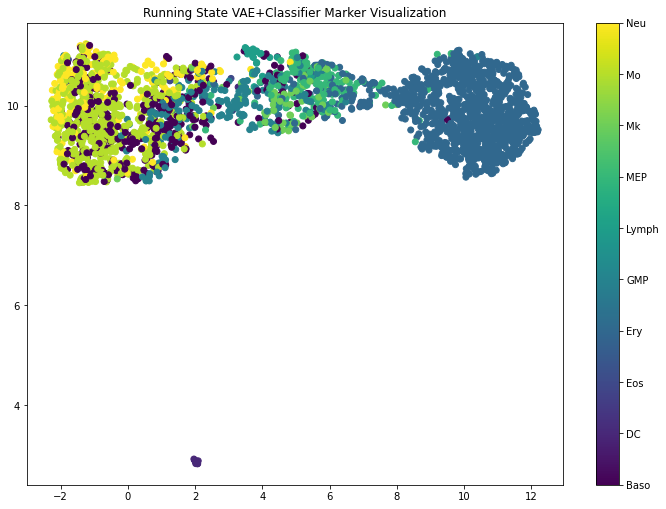

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


New Learning Rate 0.0006300037000000001


Validation sanity check: 0it [00:00, ?it/s]

Training: 9it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



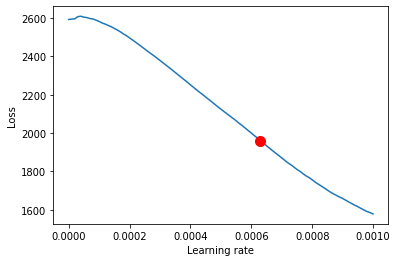

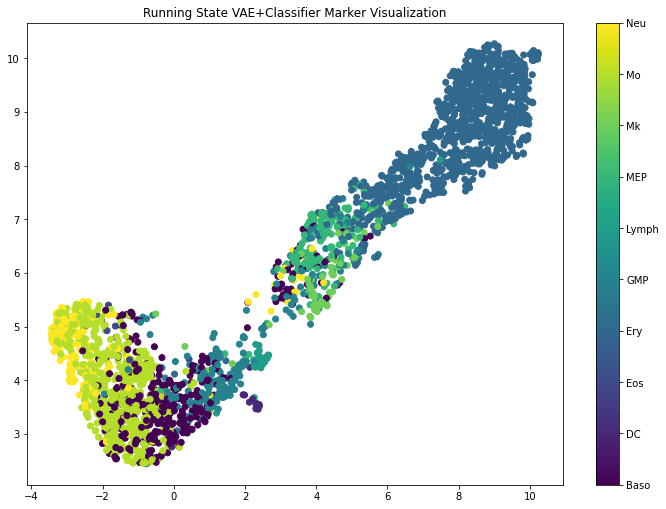

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


New Learning Rate 0.0006400036000000001


Validation sanity check: 0it [00:00, ?it/s]

Training: 9it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



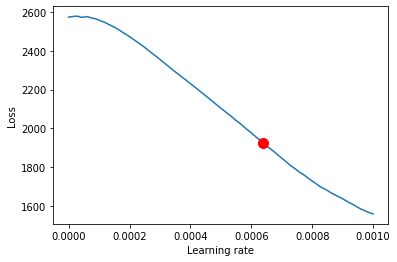

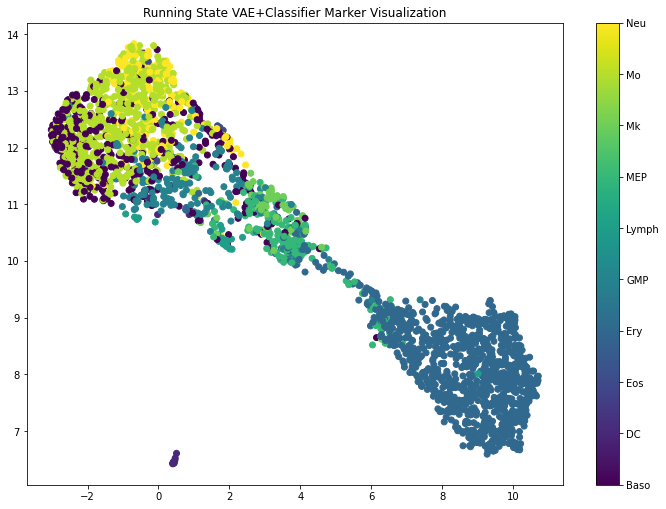

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


New Learning Rate 0.0005900041


Validation sanity check: 0it [00:00, ?it/s]

Training: 9it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



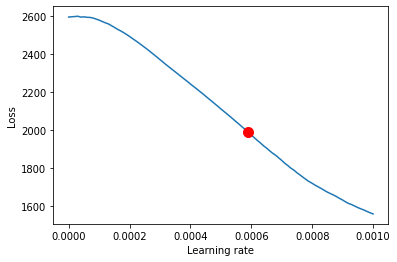

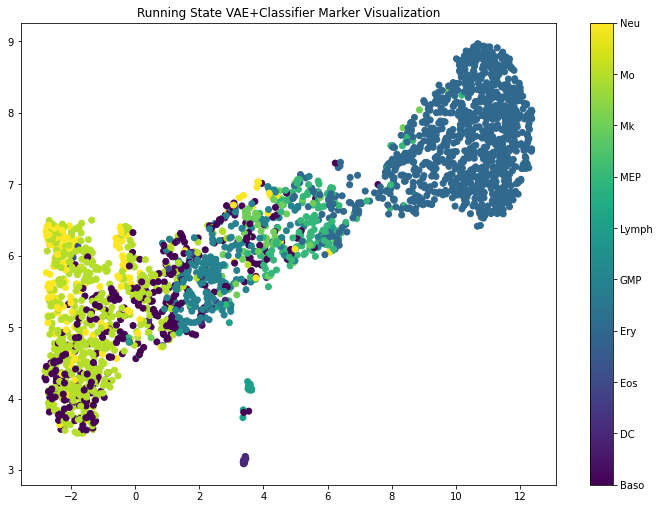

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 929 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 804 K 
4 | dec_logvar             | Sequential | 804 K 
5 | weight_creator         | Sequential | 1.7 M 
6 | classification_decoder | Sequential | 7.4 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.877    Total estimated model params size (MB)


New Learning Rate 0.0006300037000000001


Validation sanity check: 0it [00:00, ?it/s]

Training: 9it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



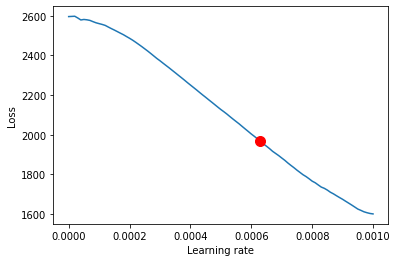

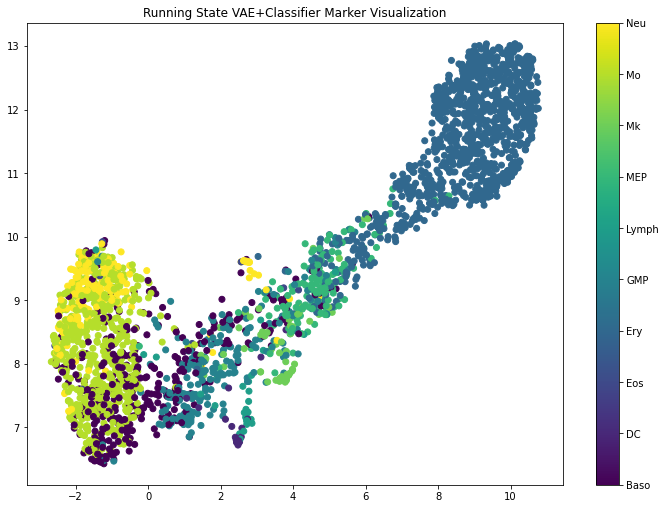

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = RunningState_VAE_Classifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE+Classifier Marker Visualization', path = viz_save_path + 'runningstate_vae+classifier_markers_{}.png'.format(tryy), markers = markers)

In [ ]:
results

(0.13003663003663002,
 {'0': {'f1-score': 0.8129032258064518,
   'precision': 0.8181818181818182,
   'recall': 0.8076923076923077,
   'support': 78},
  '1': {'f1-score': 0.6666666666666666,
   'precision': 1.0,
   'recall': 0.5,
   'support': 4},
  '2': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 3},
  '3': {'f1-score': 0.9841269841269841,
   'precision': 0.9730941704035875,
   'recall': 0.9954128440366973,
   'support': 218},
  '4': {'f1-score': 0.7032967032967034,
   'precision': 0.6808510638297872,
   'recall': 0.7272727272727273,
   'support': 44},
  '5': {'f1-score': 0.6666666666666665,
   'precision': 0.75,
   'recall': 0.6,
   'support': 5},
  '6': {'f1-score': 0.5538461538461539,
   'precision': 0.5,
   'recall': 0.6206896551724138,
   'support': 29},
  '7': {'f1-score': 0.4444444444444444,
   'precision': 0.8,
   'recall': 0.3076923076923077,
   'support': 13},
  '8': {'f1-score': 0.9224137931034483,
   'precision': 0.8991596638655462,
   'recall': 0.94690265

## Concrete VAE

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

In [ ]:
results = np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)

In [ ]:
results

## LassoNet

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



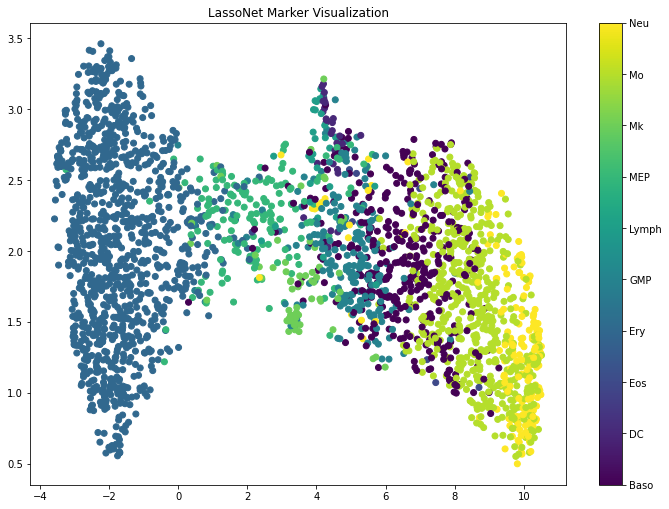

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



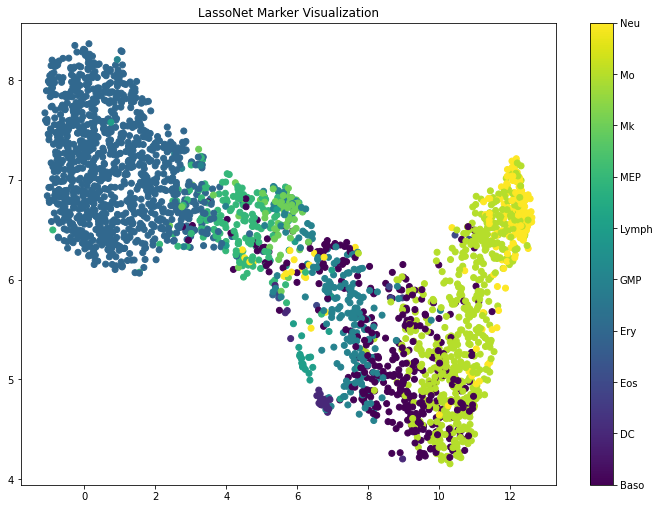

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



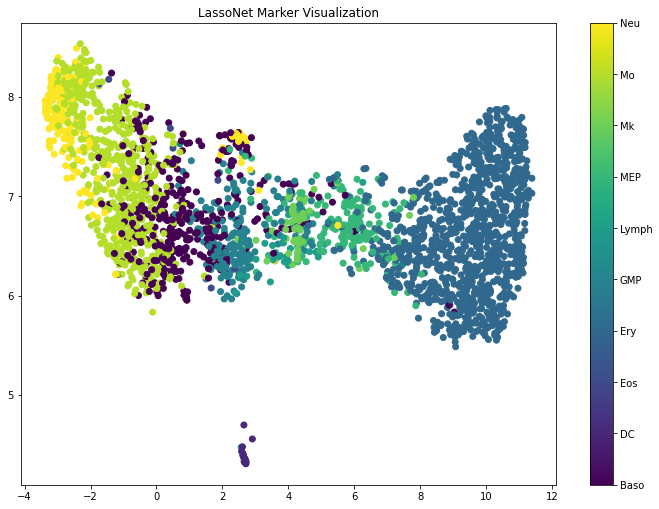

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



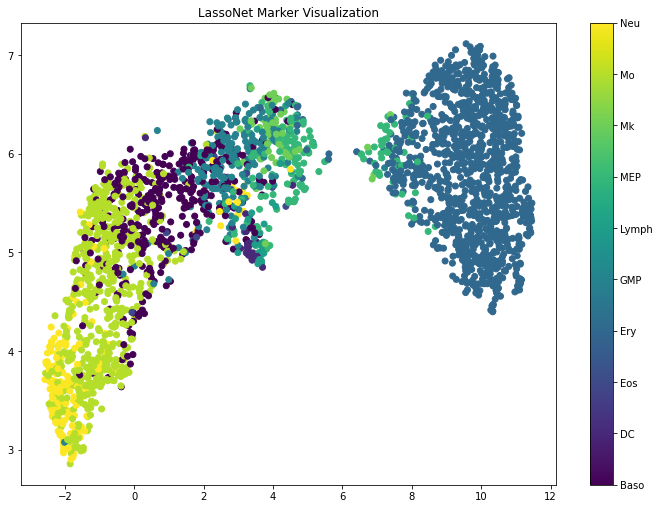

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



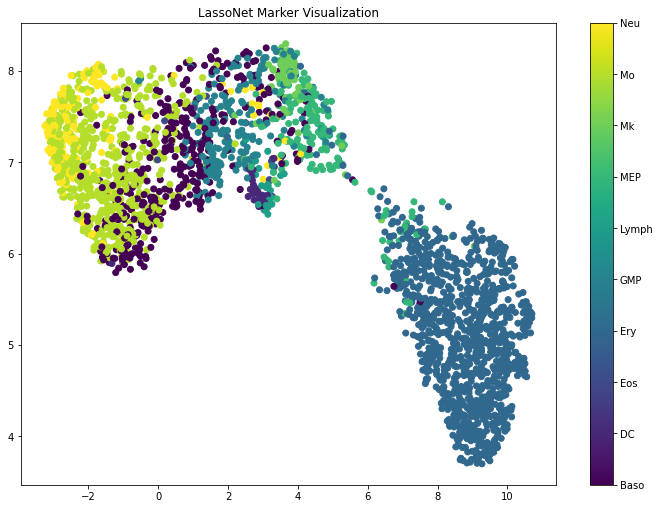

In [ ]:
k = 50
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, z_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

In [ ]:
results

(0.1282051282051282,
 {'0': {'f1-score': 0.7814569536423841,
   'precision': 0.8428571428571429,
   'recall': 0.7283950617283951,
   'support': 81},
  '1': {'f1-score': 0.7499999999999999,
   'precision': 1.0,
   'recall': 0.6,
   'support': 5},
  '3': {'f1-score': 0.9749430523917996,
   'precision': 0.9727272727272728,
   'recall': 0.9771689497716894,
   'support': 219},
  '4': {'f1-score': 0.764705882352941,
   'precision': 0.7090909090909091,
   'recall': 0.8297872340425532,
   'support': 47},
  '5': {'f1-score': 0.5714285714285715,
   'precision': 1.0,
   'recall': 0.4,
   'support': 5},
  '6': {'f1-score': 0.5666666666666667,
   'precision': 0.425,
   'recall': 0.85,
   'support': 20},
  '7': {'f1-score': 0.5925925925925926,
   'precision': 1.0,
   'recall': 0.42105263157894735,
   'support': 19},
  '8': {'f1-score': 0.923076923076923,
   'precision': 0.9152542372881356,
   'recall': 0.9310344827586207,
   'support': 116},
  '9': {'f1-score': 0.8125,
   'precision': 0.866666666666

### Get Model Metrics from KNNs Classifiers

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae_indices_{}.npy',
                                  model_save_path+'runningstate_vae_markers_{}.npy',
                                  model_save_path+'runningstate_vae_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_classifier_indices_{}.npy',
                                  model_save_path+'runningstate_classifier_markers_{}.npy',
                                  model_save_path+'runningstate_classifier_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_markers_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which

# Results and Visualizations

## Accuracies and F1

In [ ]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('RunningGumbel VAE', 'runningstate_vae_results_{}.npy', 'runningstate_vae_knn_results_{}.npy'),
 ('RunningGumbel Classifier', 'runningstate_classifier_results_{}.npy', 'runningstate_classifier_knn_results_{}.npy'),
 ('RunningGumbel VAE+Classifier', 'runningstate_vae+classifier_results_{}.npy', 'runningstate_vae+classifier_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  ...  Weighted F1 Standard Deviation
All Markers                                 0.188278  ...                        0.012679
L1 VAE                                      0.534432  ...                        0.030976
Smash RF                                    0.116484  ...                        0.001634
SMaSH DNN                                   0.191941  ...                        0.044269
RankCorr                                    0.147253  ...                        0.012534
Global Gate VAE                             0.361538  ...                        0.024785
RunningGumbel VAE                           0.130403  ...                        0.011867
RunningGumbel Classifier                    0.138828  ...                        0.009486
RunningGumbel VAE+Classifier                0.143956  ...                        0.008222
Concrete VAE                                0.411722  ...                        0.030689
LassoNet                                    0.122344  ...                        0.005484

[11 rows x 4 columns]

In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  ...  Weighted F1 Standard Deviation
All Markers                                 0.331136  ...                        0.023593
L1 VAE                                      0.588645  ...                        0.054785
Smash RF                                    0.212454  ...                        0.006804
SMaSH DNN                                   0.293773  ...                        0.040700
RankCorr                                    0.248718  ...                        0.020075
Global Gate VAE                             0.416117  ...                        0.038948
RunningGumbel VAE                           0.243956  ...                        0.016606
RunningGumbel Classifier                    0.225641  ...                        0.021585
RunningGumbel VAE+Classifier                0.274359  ...                        0.027518
Concrete VAE                                0.477289  ...                        0.049499
LassoNet                                    0.226007  ...                        0.007318

[11 rows x 4 columns]

## Confusion Matrices

k = 50

k = 50

### All Markers Baseline

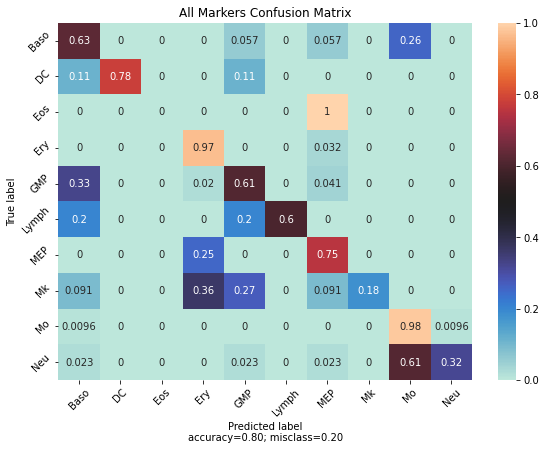

In [ ]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [ ]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

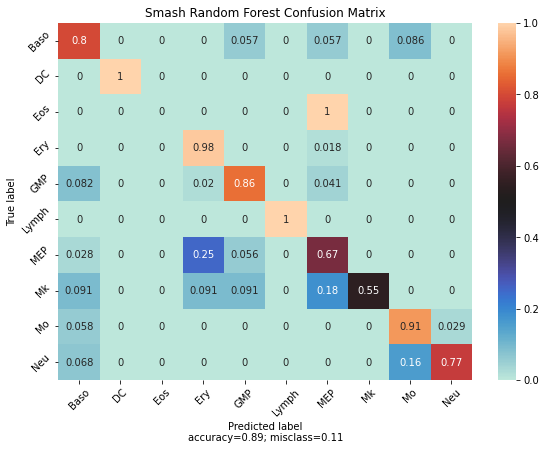

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap='icefire')

### Smash DNN

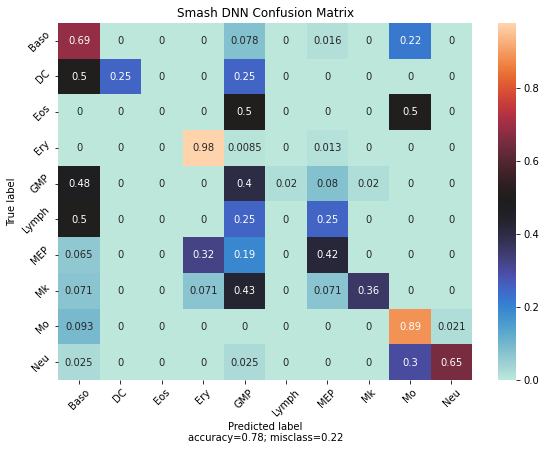

In [ ]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

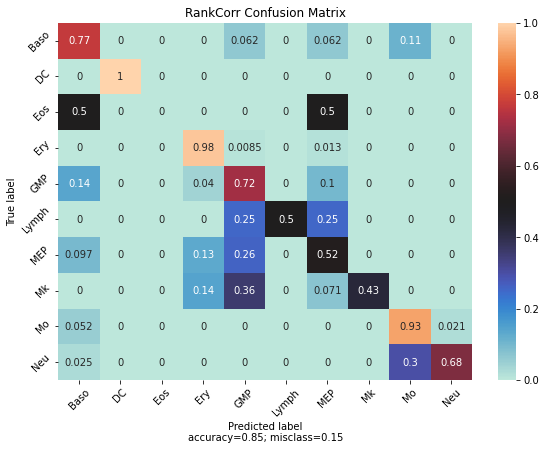

In [ ]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap='icefire')

### L1 VAE

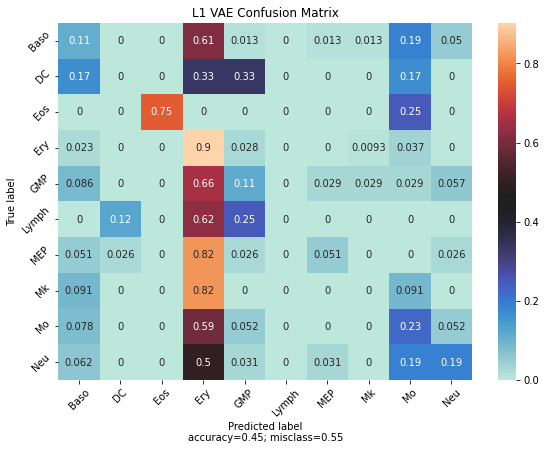

In [ ]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap='icefire')

### Global Gate VAE

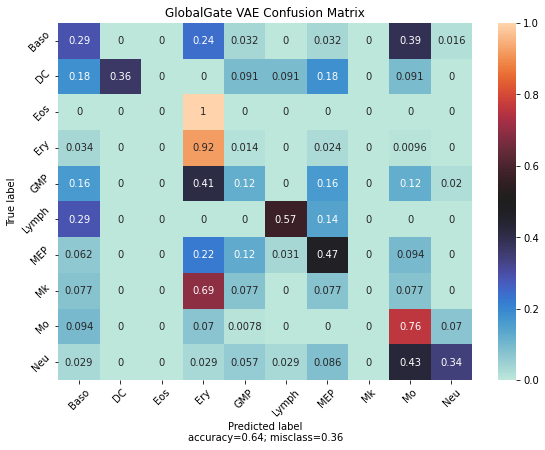

In [ ]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap='icefire')

### Running Gumbel VAE

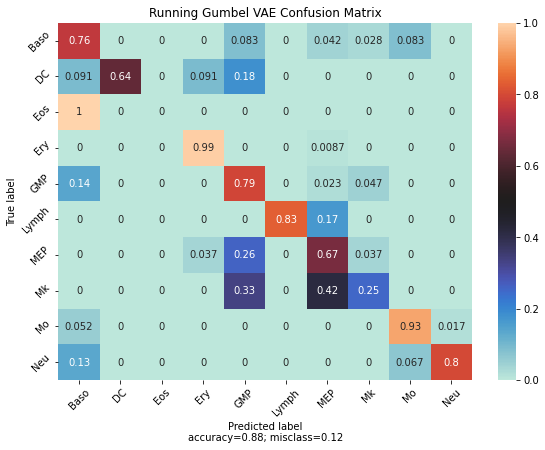

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE Confusion Matrix', save_path = viz_save_path + 'runningstate_vae_cm.pdf', cmap='icefire')

### Running Gumbel Classifier


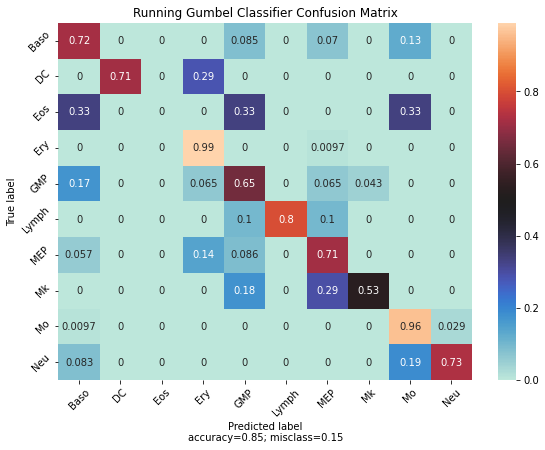

In [ ]:
results =  np.load(model_save_path + 'runningstate_classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_classifier_cm.pdf', cmap='icefire')

### RunningState VAE+Classifier

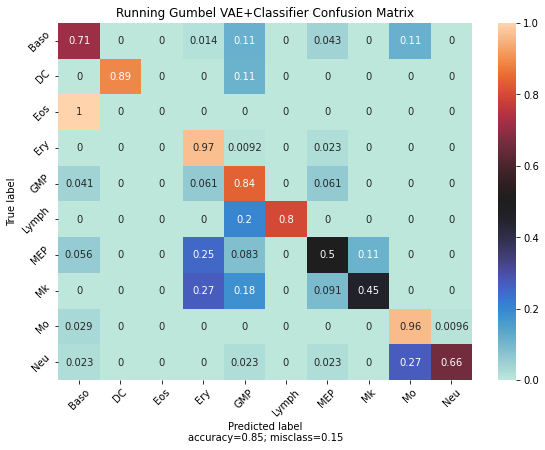

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE+Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_vae+classifier_cm.pdf', cmap = 'icefire')

### Concrete VAE

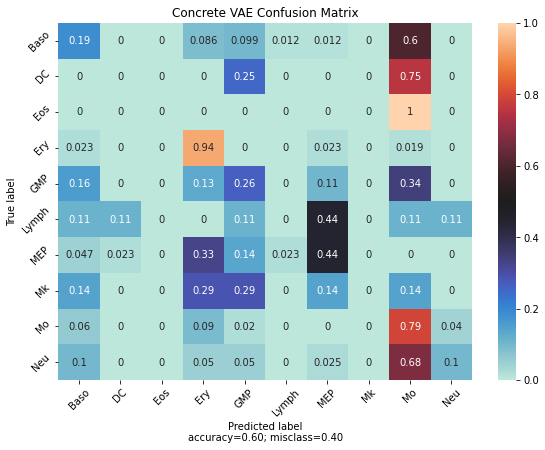

In [ ]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap='icefire')

## LassoNet

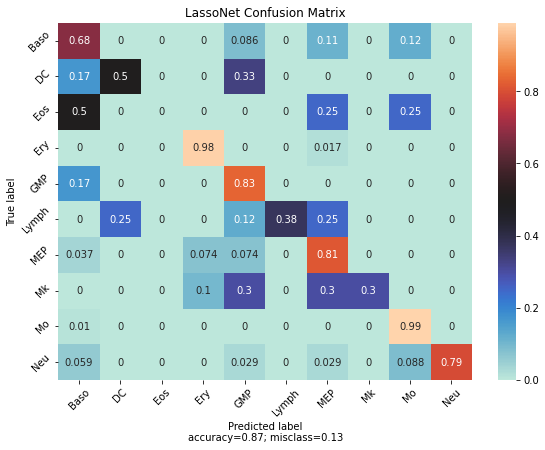

In [ ]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')

## UMap Visualization

In [ ]:
import cv2

In [ ]:
img = cv2.imread(viz_save_path + 'smash_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'rankcorr_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

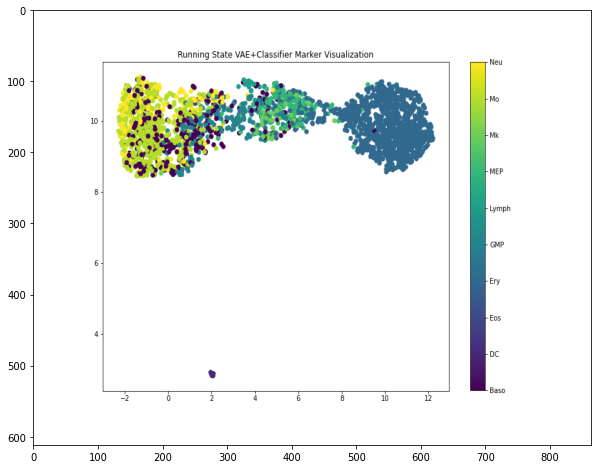

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae+classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'concrete_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

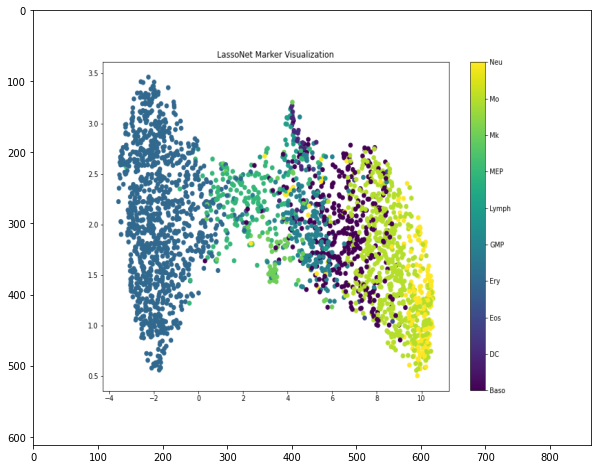

In [ ]:
img = cv2.imread(viz_save_path + 'lasso_net_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

## Visualizing Reconstructions

from first model of each

## L1 VAE

In [ ]:
model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_{}.ckpt'.format(1))
l1_vae_markers = np.load(model_save_path + 'l1_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'L1 VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_l1_vae_{}.png'.format(1), markers = l1_vae_markers)

### Global Gate VAE

In [ ]:
model = load_model(VAE_Gumbel_GlobalGate, model_save_path + 'globalgate_vae_{}.ckpt'.format(1))
globalgate_vae_markers = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Global Gate VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_globalgate_vae_{}.png'.format(1), markers = globalgate_vae_markers)

### Running State Gumbel VAE

In [ ]:
model = load_model(VAE_Gumbel_RunningState, model_save_path + 'runningstate_vae_{}.ckpt'.format(1))


In [ ]:
runningstate_vae_markers = np.load(model_save_path + 'runningstate_vae_markers_{}.npy'.format(1), allow_pickle=True)

In [ ]:
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]

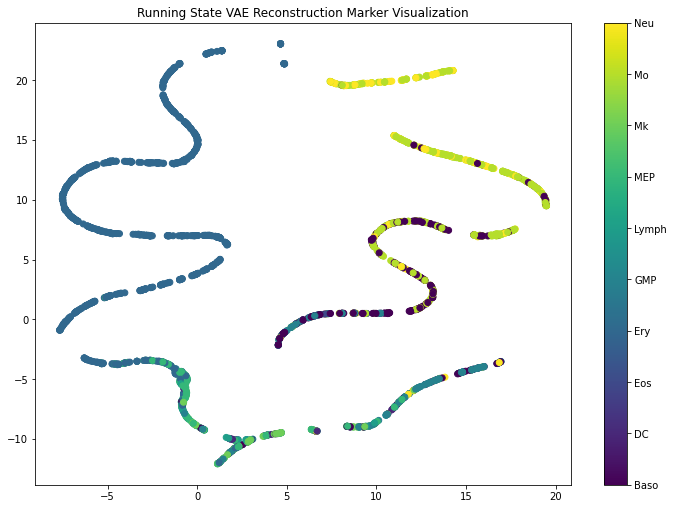

In [ ]:
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_runningstate_vae_{}.png'.format(1), markers = runningstate_vae_markers)

### RunningState VAE+Classifier

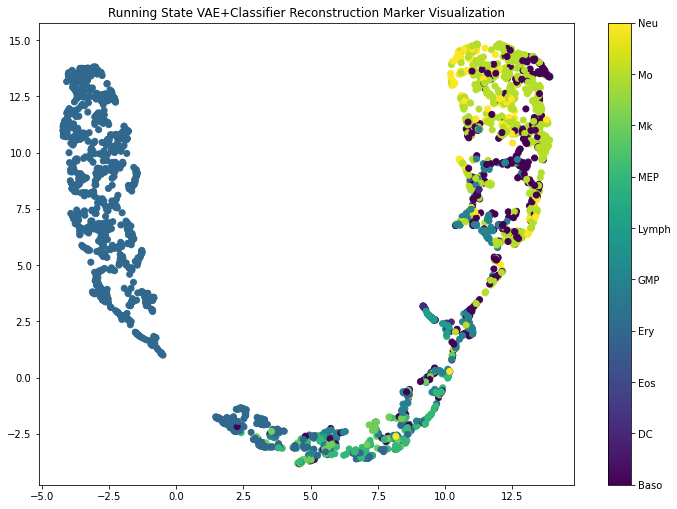

In [ ]:
model = load_model(RunningState_VAE_Classifier, model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(1))
runningstate_vae_classifier_markers = np.load(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE+Classifier Reconstruction Marker Visualization', 
                         path = viz_save_path + 'recon_runningstate_vae+classifier_{}.png'.format(1), markers = runningstate_vae_classifier_markers)

Concrete VAE

In [ ]:
model = load_model(ConcreteVAE_NMSL, model_save_path + 'concrete_vae_{}.ckpt'.format(1))
concrete_vae_markers = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Concrete VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_concrete_vae_{}.png'.format(1), markers = concrete_vae_markers)

# Things to note for paper

PySmash uses a seed internally so the model is deterministic to a particular dataset. We used various different train seeds, whereas the smash paper uses the whole dataset for the data.

For smash DNN, to select the markers, I had to use all the data. Couldn't just use train and val set.